# Deep Learning with PyTorch : Build a Generative Adversarial Network

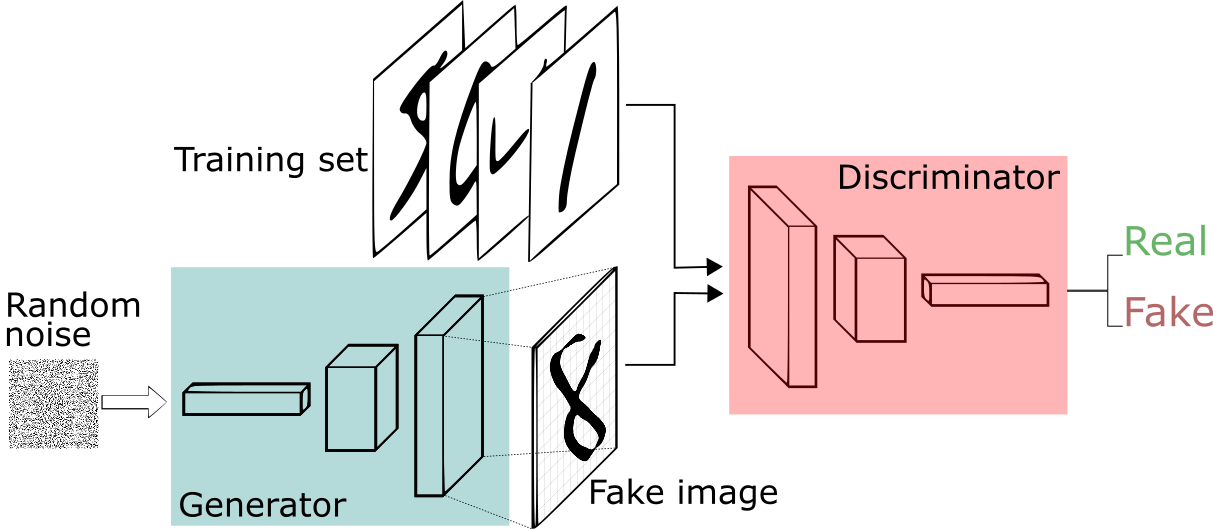

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [ ]:
device = 'cuda'
batch_size = 128
noise_dim = 64
epochs = 40

lr = 0.001

beta_1 = 0.1
beta_2 = 0.99


# Load MNIST Dataset

In [2]:
from torchvision import datasets, transforms as T


In [4]:
transform = T.Compose([
          T.RandomRotation((-20,20)),
          T.ToTensor()
])

In [5]:
trainsets = datasets.MNIST('MNIST/' , train = True, download = True, transform = transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 146688275.53it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105703048.71it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 80097881.67it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5786916.39it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



label is :  2


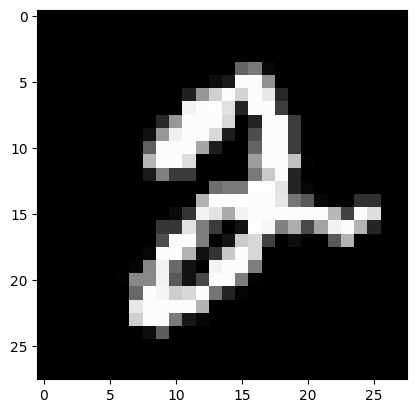

In [ ]:
image, label = trainsets[5]

print("label is : ",label)
plt.imshow(image.squeeze(), cmap = 'gray')

# Load Dataset Into Batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainsets, shuffle = True , batch_size = batch_size)

In [ ]:
print("the size of the trainloader is :",len(trainloader))

the size of the trainloader is : 469


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

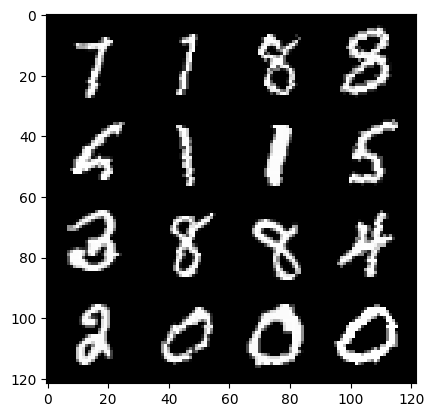

In [ ]:
images,labels = next(iter(trainloader))

show_tensor_images(images)

# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [ ]:
def get_disc_bloc(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = get_disc_bloc(1,16,(3,3),2)
    self.block_2 = get_disc_bloc(16,32,(5,5),2)
    self.block_3 = get_disc_bloc(32,64,(5,5),2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features=1)

  def forward(self, images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [ ]:
D = Discriminator()
D.to(device)

summary(D, input_size= (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [ ]:
class Generator(nn.Module):

  def __init__(self, noise_dim):
    super(Generator,self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)

    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

  def forward(self, r_noise_vec):
    x = r_noise_vec.view(-1, self.noise_dim, 1, 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [ ]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1,beta_2))

G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1,beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | D_loss : 0.6386288977635186 | G_loss : 0.8175699648572438 


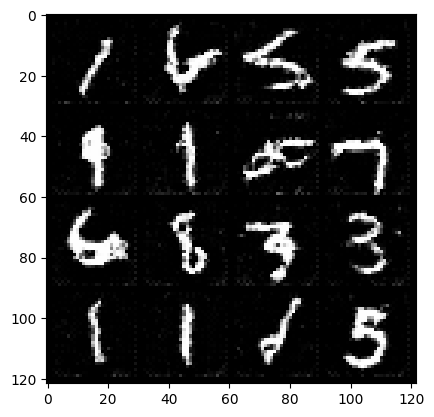

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | D_loss : 0.6394769586225563 | G_loss : 0.8190348441921064 


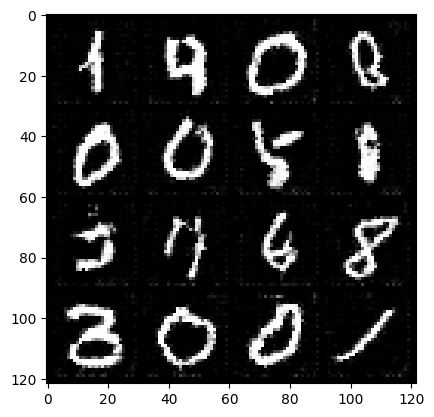

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | D_loss : 0.6378996283260744 | G_loss : 0.8208076135436101 


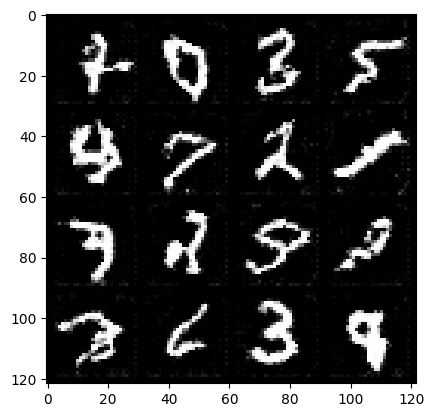

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | D_loss : 0.6374825389146297 | G_loss : 0.8252673915454319 


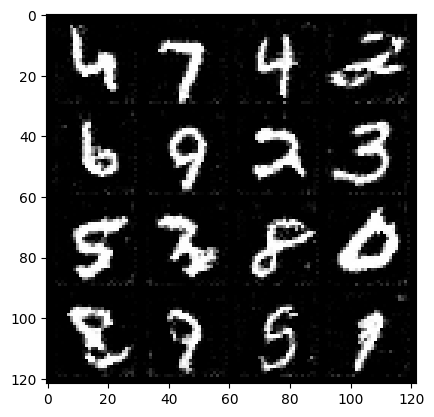

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | D_loss : 0.6350646979773222 | G_loss : 0.830334006342044 


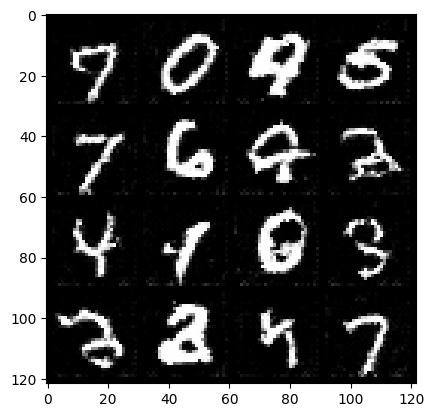

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | D_loss : 0.6343586490606703 | G_loss : 0.8309511187742514 


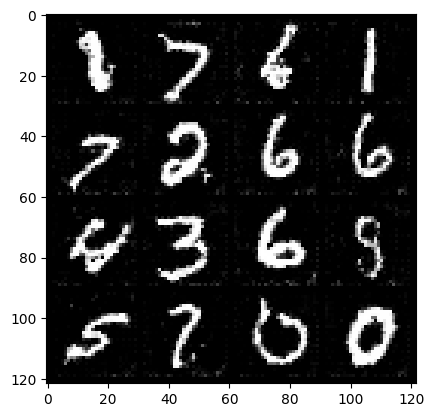

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | D_loss : 0.632018502841372 | G_loss : 0.8348017120157986 


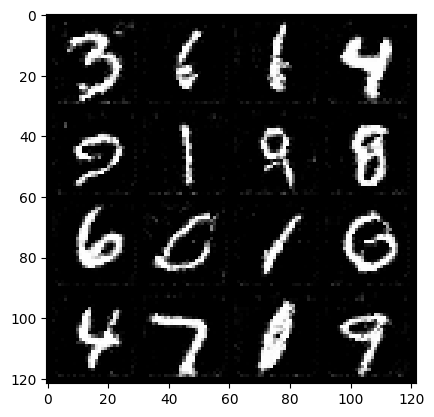

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | D_loss : 0.6306501236805784 | G_loss : 0.8423190635404607 


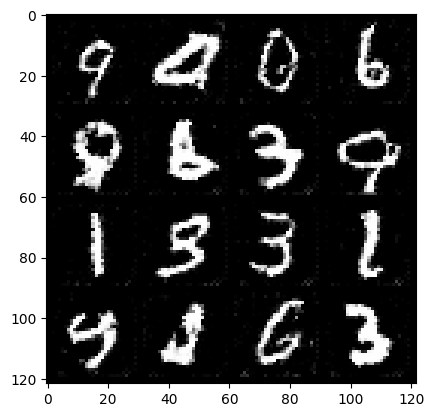

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | D_loss : 0.6298096793801037 | G_loss : 0.8458393946893688 


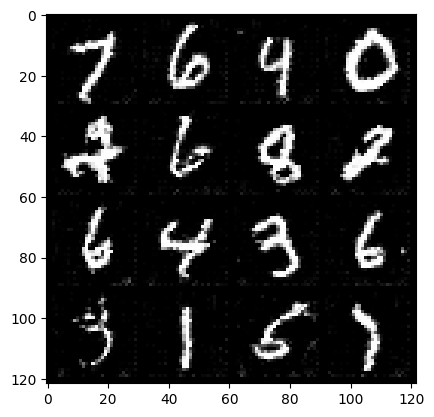

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | D_loss : 0.6267266894962742 | G_loss : 0.8484906433487752 


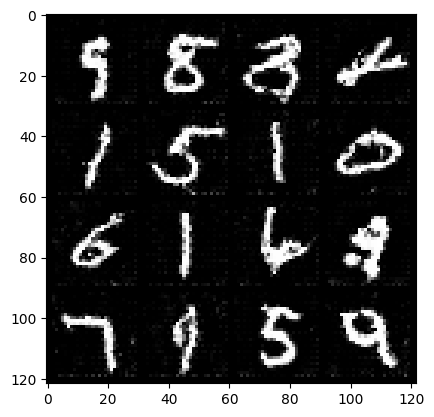

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | D_loss : 0.6246229004758254 | G_loss : 0.8572288522842342 


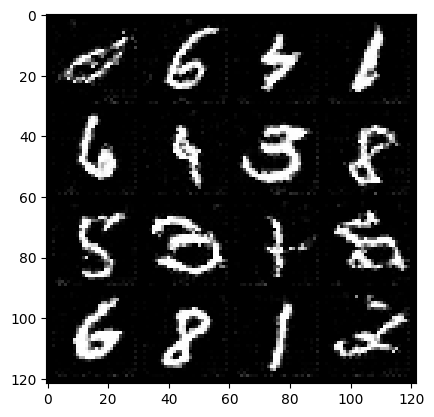

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | D_loss : 0.623007114889271 | G_loss : 0.8623932059893984 


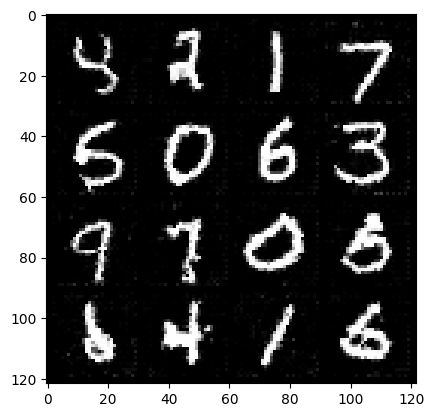

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | D_loss : 0.6237964222171922 | G_loss : 0.8638255003927104 


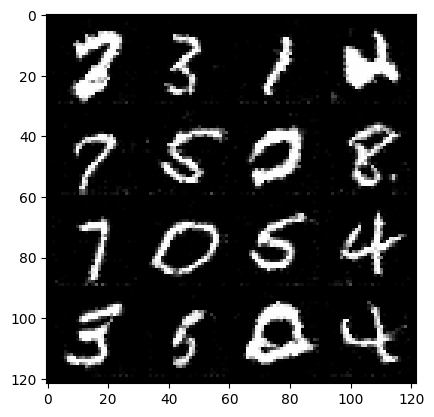

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | D_loss : 0.6228738713111959 | G_loss : 0.8648358279708098 


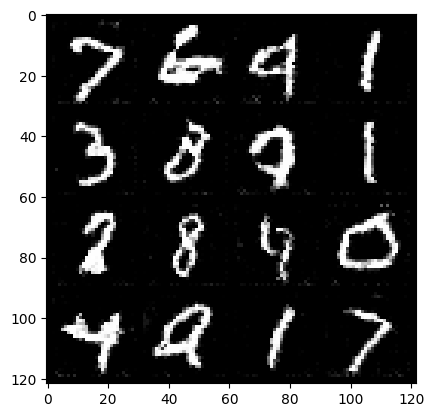

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | D_loss : 0.6228021495123662 | G_loss : 0.867925586603852 


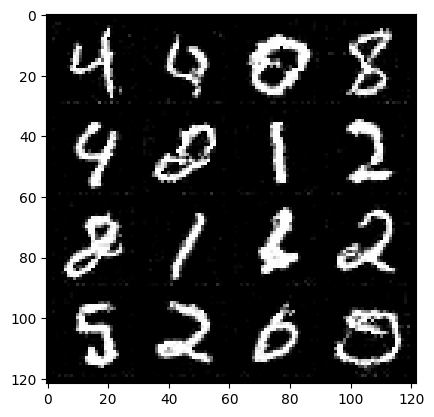

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | D_loss : 0.6231563231075751 | G_loss : 0.8689396106866377 


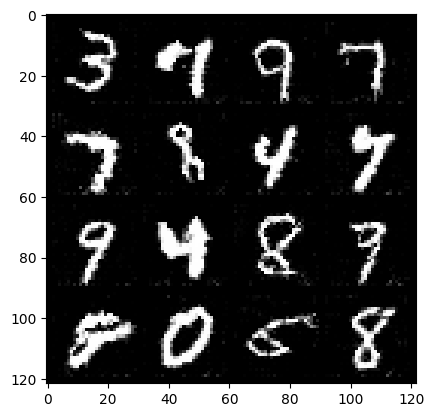

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | D_loss : 0.6225484619770986 | G_loss : 0.8728803257698189 


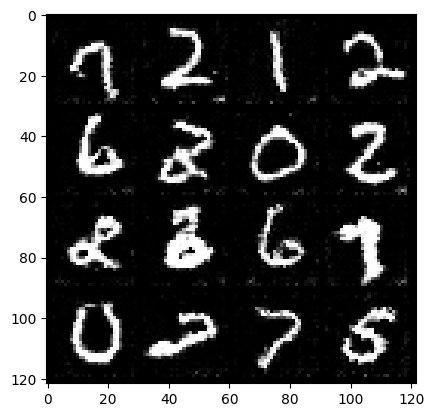

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | D_loss : 0.6212376128635935 | G_loss : 0.8749180025637531 


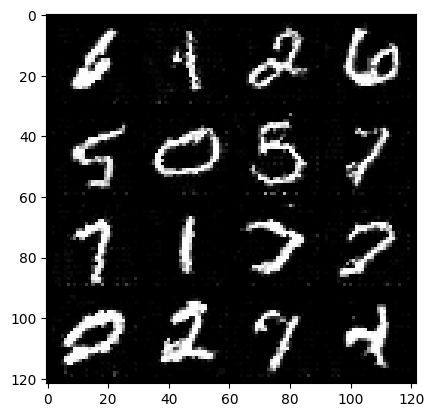

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | D_loss : 0.6220449668003806 | G_loss : 0.8766232538324937 


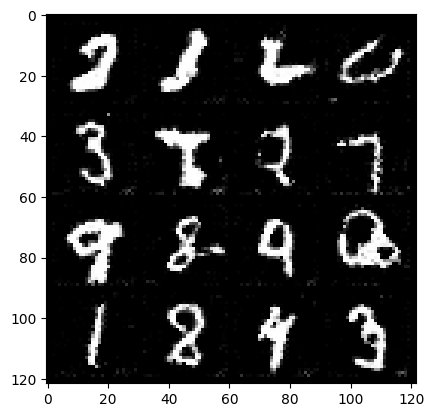

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | D_loss : 0.6199276231245191 | G_loss : 0.8831955357146924 


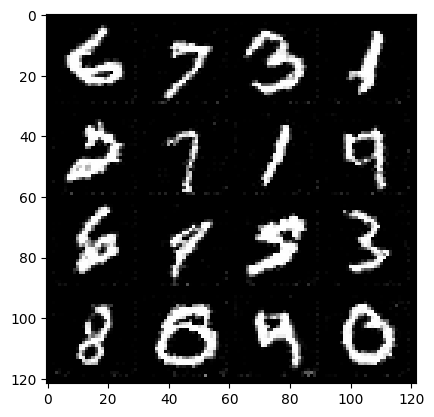

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 21 | D_loss : 0.6183673251412316 | G_loss : 0.8825499993651661 


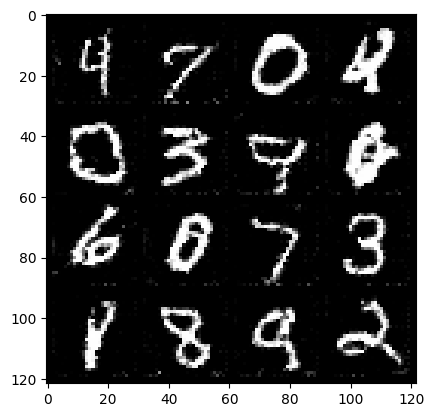

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 22 | D_loss : 0.6183378795570911 | G_loss : 0.8898397609114901 


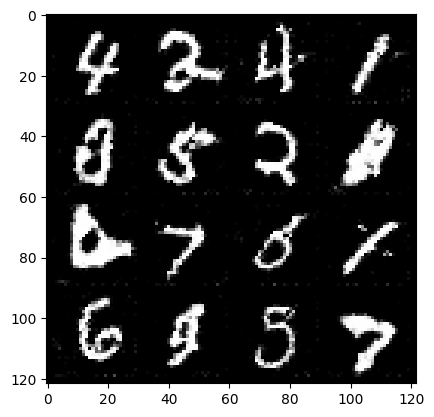

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 23 | D_loss : 0.6180371863247235 | G_loss : 0.8897474777978113 


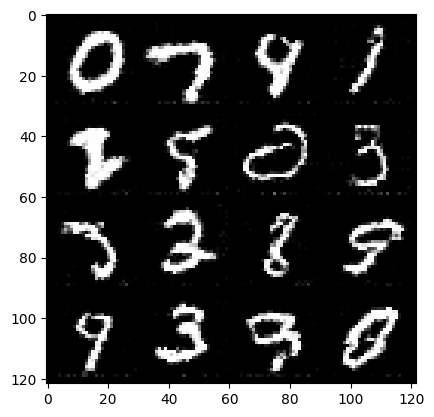

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 24 | D_loss : 0.6185490238641117 | G_loss : 0.8930488897284974 


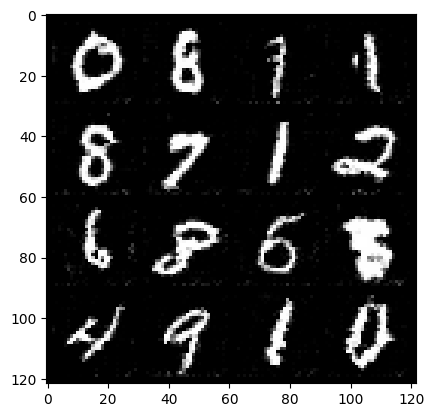

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 25 | D_loss : 0.6160321112380607 | G_loss : 0.8942335184449072 


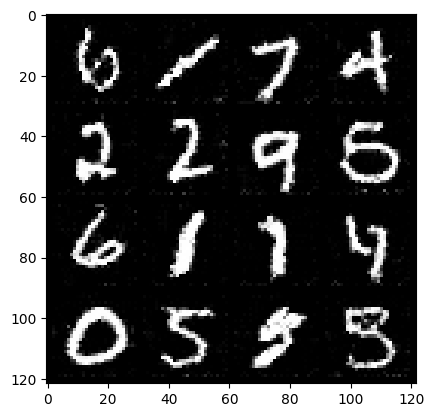

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 26 | D_loss : 0.6167562959799125 | G_loss : 0.8937777106695847 


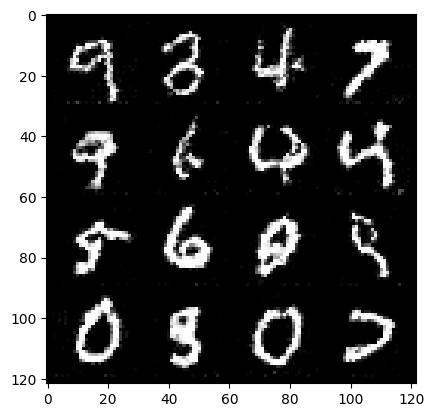

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 27 | D_loss : 0.6162851830281174 | G_loss : 0.8982496556442684 


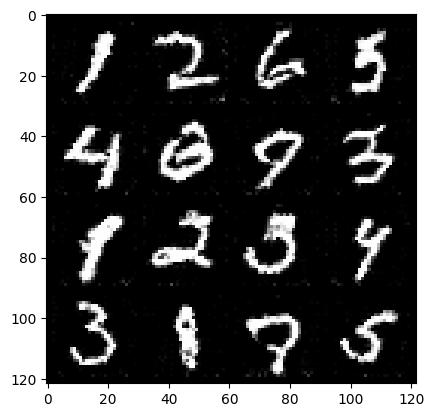

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 28 | D_loss : 0.6147747769284604 | G_loss : 0.9014499747931067 


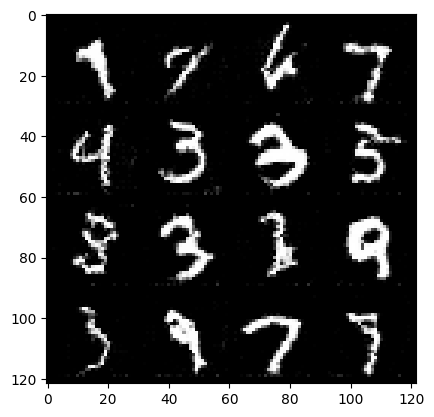

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 29 | D_loss : 0.616194780828602 | G_loss : 0.9061855793253445 


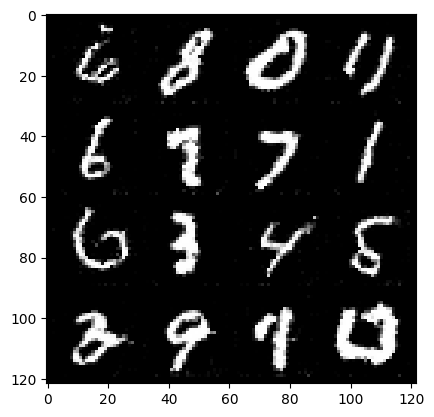

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 30 | D_loss : 0.6141141701354655 | G_loss : 0.9055973748916756 


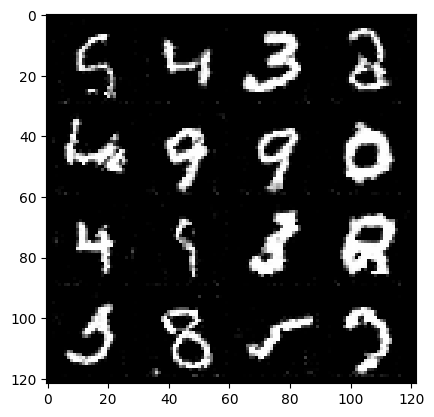

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 31 | D_loss : 0.6138550752261555 | G_loss : 0.9051628148377832 


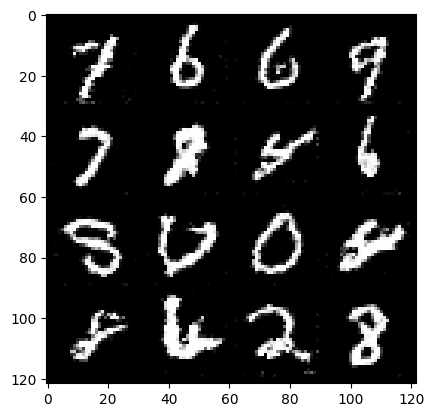

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 32 | D_loss : 0.6155416873980687 | G_loss : 0.9058891283169485 


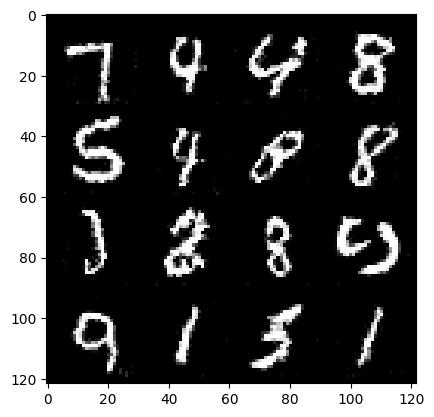

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 33 | D_loss : 0.6121252630311035 | G_loss : 0.9124776095723801 


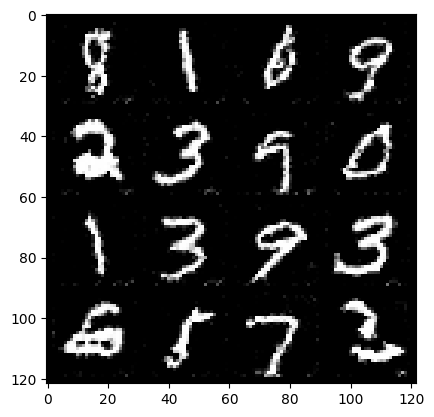

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 34 | D_loss : 0.6114869274056034 | G_loss : 0.9145859861170559 


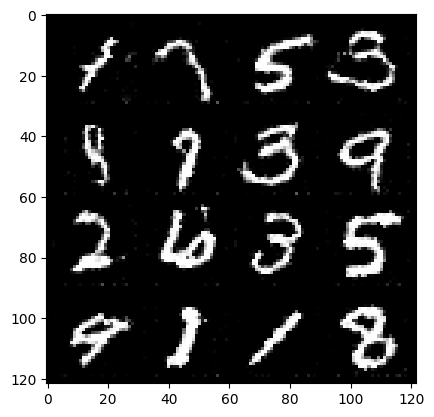

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 35 | D_loss : 0.6107089603379336 | G_loss : 0.9154848849087127 


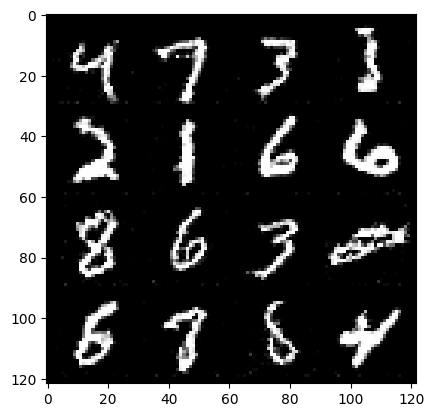

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 36 | D_loss : 0.6089389172952566 | G_loss : 0.9238021274619519 


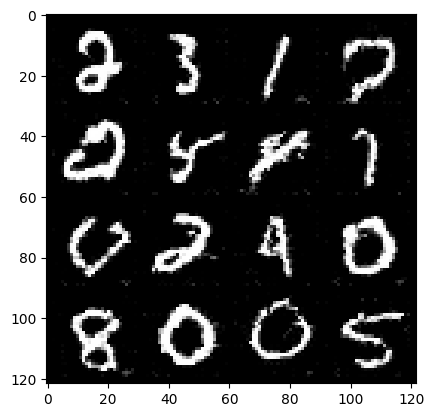

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 37 | D_loss : 0.6072836401365967 | G_loss : 0.9270817307012675 


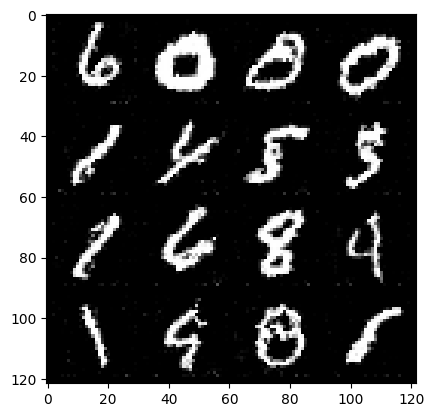

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 38 | D_loss : 0.6055943477890893 | G_loss : 0.9319784857316821 


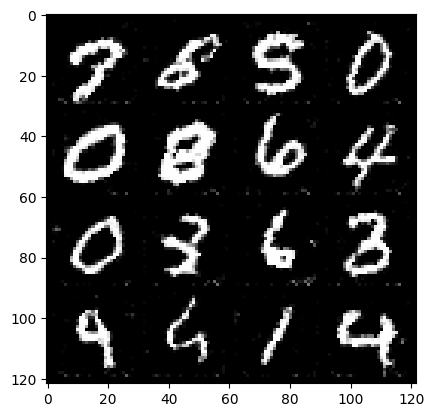

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 39 | D_loss : 0.6033072556768145 | G_loss : 0.9391938201400009 


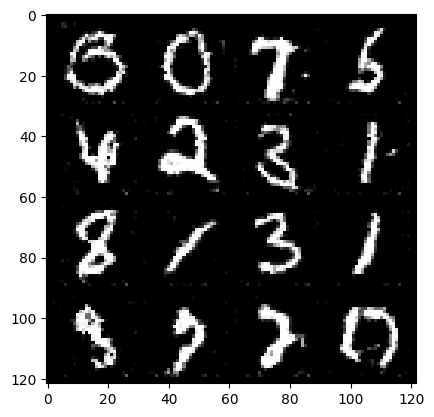

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 40 | D_loss : 0.6063320705377216 | G_loss : 0.9411960184447038 


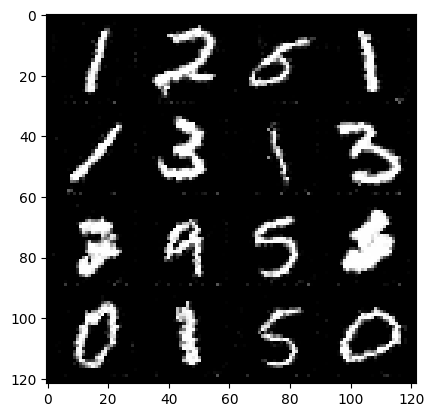

In [ ]:
for i in range(epochs):
  total_D_loss = 0.0
  total_G_loss = 0.0

  for real_img, _ in tqdm(trainloader):

    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device=device)

    #loss and weights of D

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_D_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    #loss and weights of G

    G_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_G_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_D_loss / len(trainloader)
  avg_g_loss = total_G_loss / len(trainloader)

  print("Epoch : {} | D_loss : {} | G_loss : {} ".format(i+1, avg_d_loss, avg_g_loss))
  show_tensor_images(fake_img)

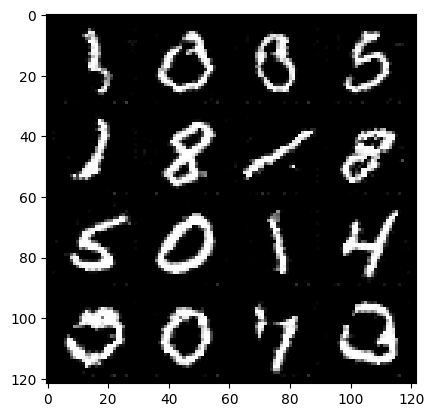

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)